In [1]:
from aiida.plugins import DataFactory
import aiida
aiida.load_profile()

Profile<uuid='aaaefae20eac49f892e60b4593a470e3' name='quicksetup'>

# 外部ファイル化とplugin登録

新規pluginをstableposition2/に置いた。以下のファイルははstablepostion/以下と中身が同じである。
```
stablepositon2/
stablepositon2/common2/workflow/energy.py
stablepositon2/common2/workflowforce.py
stablepositon2/steepestdescnt2/workflow/new_x.py
```

以下のファイルを新たに置いた。
```
stablepositon2/steepestdescnt2/workflow/stable_x.py
```

setup.jsonは以下とした。
```json
{
    "name" : "stablex2",
    "version" : 0.1,
    "author" : "Hiori Kino",
    "entry_points" : {
       "aiida.workflows": [
           "stablex2.sd_new_x = steepestdescent2.workflows.new_x: NewXChain",
           "stablex2.energy = common2.workflows.energy: EnergyChain",
           "stablex2.force = common2.workflows.force: ForceChain",
           "stablex2.stale_x = steepestdescent2.workflows.stable_x: StableXChain"
       ]
    }
}
```

stablepositon2/にてlocal install を行う。
```sh
pip install -e .
```

daemon restartを行う
```sh
verdi daemon restart --reset
```

verdi pluginを確認する。
```sh
verdi plugin list aiida.workflows
```

```console
* siesta.stm
* stablex.energy
* stablex.force
* stablex.sd_new_x
* stablex2.energy
* stablex2.force
* stablex2.sd_new_x
* stablex2.stable_x
* tbmodels.parse
```

```sh
verdi plugin list aiida.workflows stablex2.stable_x
```
```console
Description:

	No description available

Inputs:
             a:  required  Float  
           fth:  required  Float  
             x:  required  Float  
      metadata:  optional         
Outputs:
  stable_force:  required  Float  
      stable_x:  required  Float  
Exit codes:
             1:  The process has failed with an unspecified error.
             2:  The process failed with legacy failure mode.
            10:  The process returned an invalid output.
            11:  The process did not register a required output.
```

## Python再起動
jupyter Python kernelの再起動を行う。


In [2]:
from aiida.plugins import WorkflowFactory
from aiida.orm import Float, load_node
from aiida.engine import run,submit,workfunction, WorkChain, ToContext, while_
import numpy as np
import time

## StableXChainの実行を行う。

### まずはPython importを用いて実行テストを行う。

In [3]:
from stableposition2.steepestdescent2.workflows.stable_x import StableXChain
x0 = Float(2)
a = Float(0.6)
fth = Float(1e-3)

inputs = {"x":x0, "a":a, "fth":fth}
print(inputs)

result, node =  run.get_node(StableXChain, **inputs)

{'x': <Float: uuid: 5e0e4c01-5f12-4234-ac06-d9ca8c578ee7 (unstored) value: 2.0>, 'a': <Float: uuid: 6f979485-808d-44ea-8391-bec95ffe2df3 (unstored) value: 0.6>, 'fth': <Float: uuid: 5ebeb36b-25d7-48b9-97f4-ba92f22ba11e (unstored) value: 0.001>}
i,f,fth 0 -4.0 0.001
i,f,fth 1 0.8 0.001
i,f,fth 2 -0.16 0.001
i,f,fth 3 0.032 0.001
i,f,fth 4 -0.0064 0.001
i,f,fth 5 0.00128 0.001
i,f,fth 6 -0.000256 0.001


In [4]:
del StableXChain

# pluginの実行

pluginとしてrun()実行する。

In [5]:
stablexchain = WorkflowFactory("stablex2.stable_x")

x0 = Float(2)
a = Float(0.6)
fth = Float(1e-3)

inputs = {"x":x0, "a":a, "fth":fth}
print(inputs)

result, node =  run.get_node(stablexchain, **inputs)

{'x': <Float: uuid: 42139dcd-5601-43a8-91a0-8536c37bfcea (unstored) value: 2.0>, 'a': <Float: uuid: 0460382b-03b5-4fb9-8c1e-9fe41d5c23f9 (unstored) value: 0.6>, 'fth': <Float: uuid: 19c07ed6-fca9-4b9f-b605-402ff51edb9d (unstored) value: 0.001>}
i,f,fth 0 -4.0 0.001
i,f,fth 1 0.8 0.001
i,f,fth 2 -0.16 0.001
i,f,fth 3 0.032 0.001
i,f,fth 4 -0.0064 0.001
i,f,fth 5 0.00128 0.001
i,f,fth 6 -0.000256 0.001


In [6]:
print(type(result))
print(result)

<class 'dict'>
{'stable_x': <Float: uuid: d104e1ed-981f-4cc3-9626-f70c7cf1d0f0 (pk: 9395) value: 0.000128>, 'stable_force': <Float: uuid: 65414fd7-30ce-4973-8c98-9896889c5570 (pk: 9398) value: -0.000256>}


# Restart daemon

もしdaemonのrestartを忘れていたら実行する。

In [7]:
# reload daemon
! verdi daemon restart 

Deprecated: `--reset` flag is deprecated. Now, `verdi daemon restart` by default restarts the full daemon.
Profile: quicksetup
Stopping the daemon... OK
Starting the daemon with 1 workers... OK


background実行するにはpipでinstallしておく必要がある。

In [8]:
stablexchain = WorkflowFactory("stablex2.stable_x")

builder = stablexchain.get_builder()
builder.x = x0
builder.a = a
builder.fth = fth
future = submit(builder)

## Pythonでエラーが起きる場合の確認方法



### future.exceptionで確認できる。

In [9]:
print(future.pk)
print(future.exception)

9399
None


### `verdi process report PK'での確認
より詳細には `verdi process report PK'でエラーを確認する。


## 実行結果の確認

```pip install icecream```


In [15]:
from icecream import ic
while not future.is_finished:
    time.sleep(1)
    ic(future.is_finished)
ic(future.is_finished_ok)

ic| future.is_finished_ok: True


True

In [11]:
print(future.outputs.stable_x)
print(future.outputs.stable_force)

uuid: 57f3f2b9-6fe1-4952-a95d-d170351f38cd (pk: 9435) value: 0.000128
uuid: a252ca9c-0d64-47b2-8353-a08ef3a01a56 (pk: 9438) value: -0.000256


実績グラフの表示

ic| pk: 9435


Success: Output written to `9435.dot.pdf`


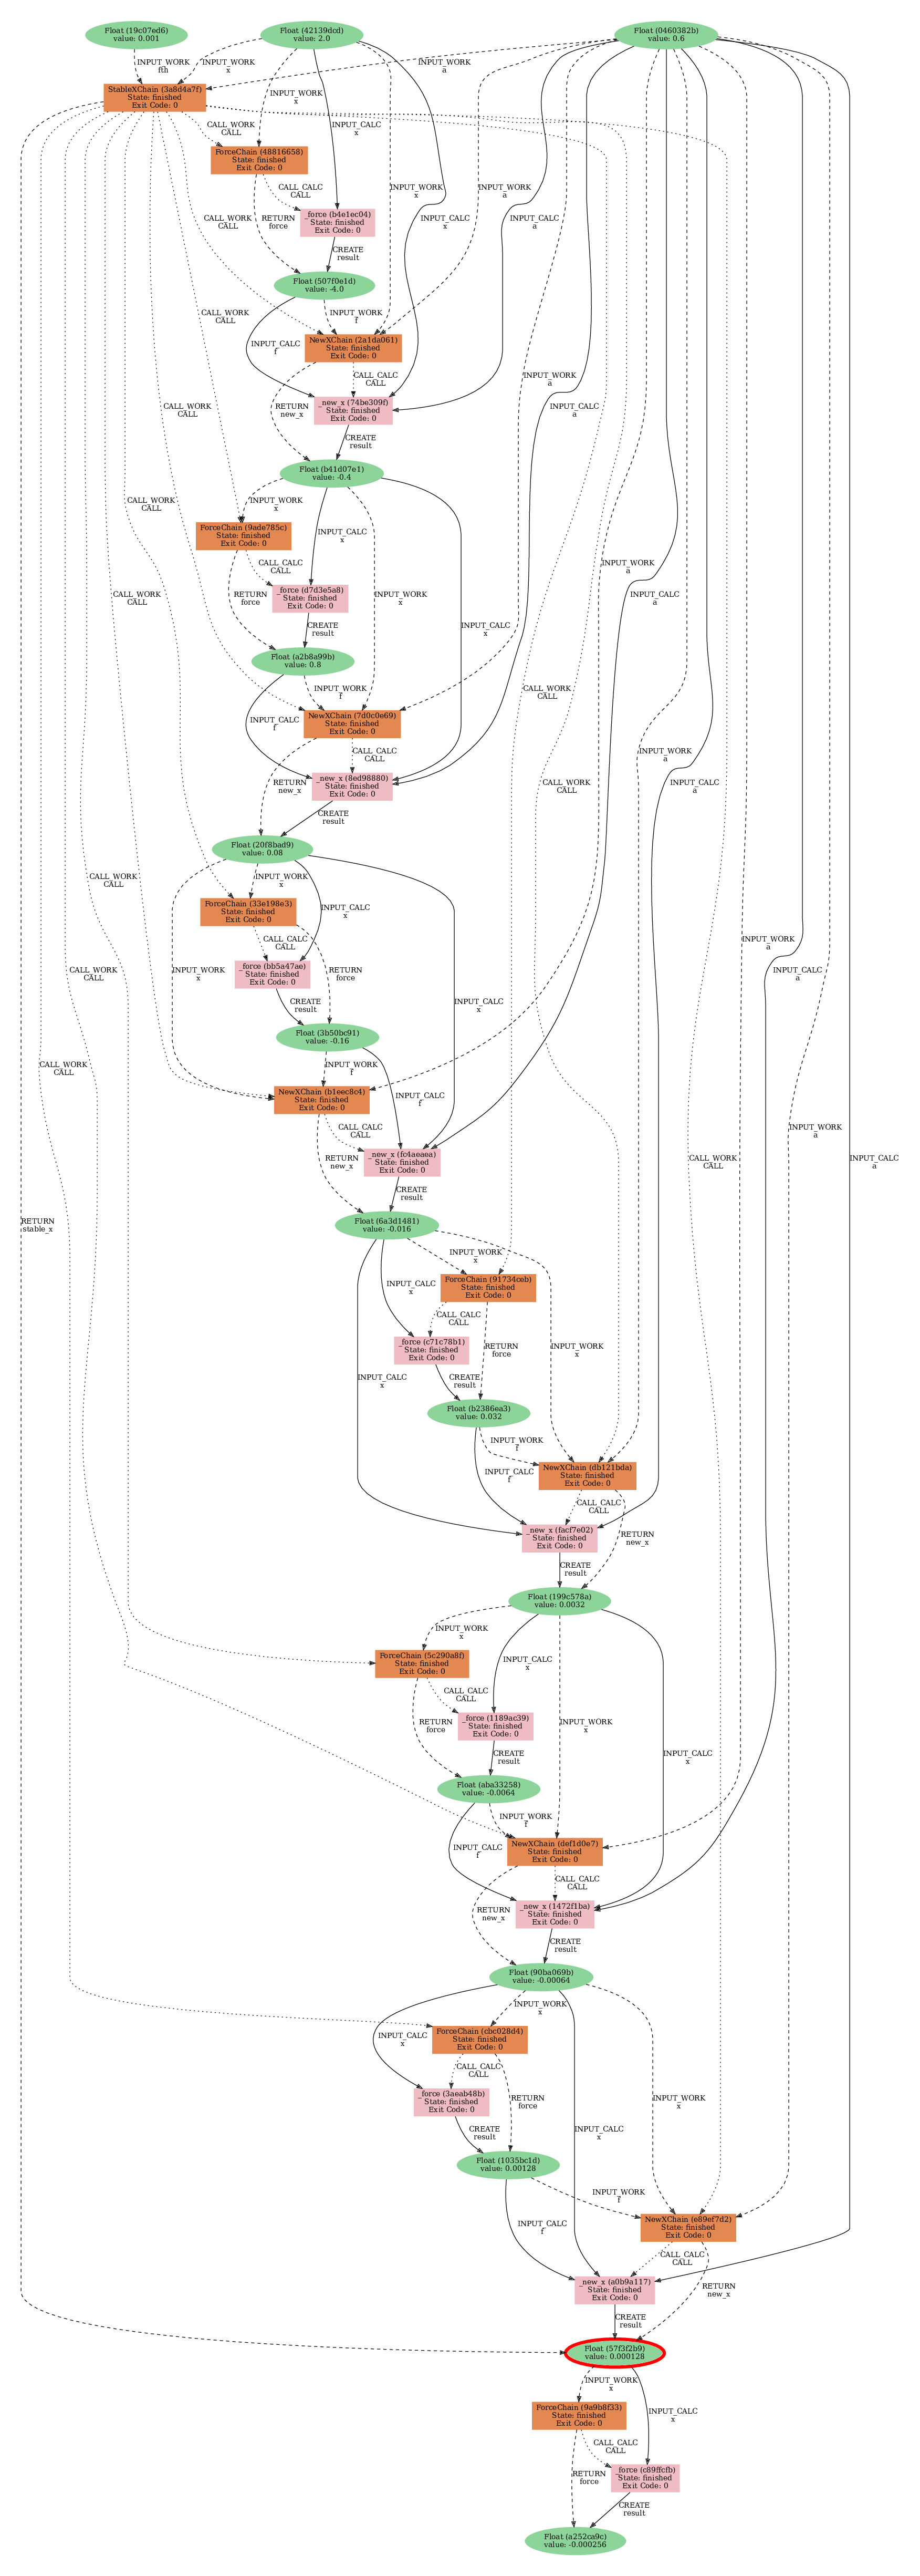

In [16]:
# This graph is big.
pk = future.outputs.stable_x.pk
ic(pk)
import subprocess
cmd = "verdi node graph generate {}".format(pk)
subprocess.call(cmd,shell=True)

from wand.image import Image as WImage
WImage(filename="{}.dot.pdf".format(pk))